# Basic CNN Model - Chromogram

In [2]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Chromogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.

In [6]:
# Pre-processed MFCC coefficients
X = np.load("C:/Users/ishaa/OneDrive/Desktop/extracted features/X-Chrom.npy")
y = np.load("C:/Users/ishaa/OneDrive/Desktop/extracted features/Y-Chrom.npy")

# Metadata
path = 'C:/Users/ishaa/OneDrive/Desktop/dataset/'
file = 'UrbanSound8K.csv'

# Use pandas read_csv directly
meta_data = pd.read_csv(path + file)
meta_data.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
def split_data(x,y,train=[],test=[],meta_data=meta_data):
    x_train,y_train=[],[]
    training_indexes,test_indexes=[],[]
    for ind in train:
        training_indexes=training_indexes+[idx_ for idx_ in meta_data.loc[(meta_data['fold'] == ind)].index.values]
    x_train=[ x[i] for i in sorted(training_indexes)]
    y_train=[ y[i] for i in sorted(training_indexes)]
    for ind in test:
        test_indexes=test_indexes+[idx_ for idx_ in meta_data.loc[(meta_data['fold'] == ind)].index.values]
    x_test=[ x[i] for i in sorted(test_indexes)]
    y_test=[ y[i] for i in sorted(test_indexes)]
    return np.array(x_train) , np.array( y_train ) ,np.array(  x_test ) , np.array( y_test) ,training_indexes,test_indexes


# Data preparation: features + metadata

Train / Test split

Note that we are using the same index order for both the Chromogram arrays and the metadata to keep track of the origin of each feature

In [10]:
indexes = []
total = len(meta_data)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes

X_train,y_train,X_test,y_test,train_split_idx,test_split_idx= split_data(X,y,train=[1,2,3,4,6],test=[5,7,8,9,10])

# Also split metadata
test_meta = meta_data.iloc[test_split_idx]
train_meta = meta_data.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 4233 		 Train split: 4499
X test shape: (4233, 40, 174) 	 X train shape: (4499, 40, 174)
y test shape: (4233,) 		 y train shape: (4499,)


# Normalizing the Data

One hot encode labels

In [11]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

Reshape data

In [15]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

Check PCA benefits

Text(0, 0.5, 'Variance (%)')

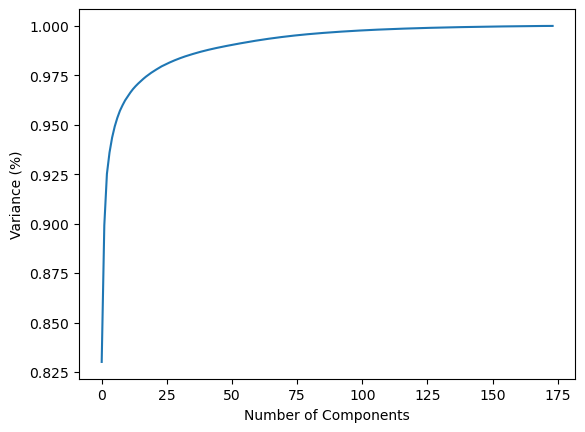

In [14]:
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

As we can see most of the variance is explained using all the features of the MFCC. This is expected since each feature gives information about the wave shape. Finally we can fit our model.

# Basic CNN Model

# Model Definition

In [18]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

Setup model optimizer and loss function


Using ADAM with default parameters to start from somewhere. Loss function is categorical cross-entropy as we are predicting between 10 classes.

In [20]:
adam = Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 172, 32)       320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 38, 172, 32)       0         
                                                                 
 batch_normalization (Batch  (None, 38, 172, 32)       128       
 Normalization)                                                  
                                                                 
 spatial_dropout2d (Spatial  (None, 38, 172, 32)       0         
 Dropout2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 170, 32)       9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 36, 170, 32)       0

# Training the model

In [22]:
num_epochs = 360
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/360
33/33 [==============================] - ETA: 0s - loss: 2.1390 - accuracy: 0.2371
Epoch 1: val_loss improved from inf to 2.42941, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 42s 1s/step - loss: 2.1390 - accuracy: 0.2371 - val_loss: 2.4294 - val_accuracy: 0.1147
Epoch 2/360
33/33 [==============================] - ETA: 0s - loss: 1.8910 - accuracy: 0.3341
Epoch 2: val_loss improved from 2.42941 to 2.22165, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 38s 1s/step - loss: 1.8910 - accuracy: 0.3341 - val_loss: 2.2216 - val_accuracy: 0.1333
Epoch 3/360
33/33 [==============================] - ETA: 0s - loss: 1.8001 - accuracy: 0.3618
Epoch 3: val_loss improved from 2.22165 to 2.14674, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 41s 1s/step - loss: 1.8001 - accuracy: 0.3618 - val_lo

33/33 [==============================] - 73s 2s/step - loss: 1.2353 - accuracy: 0.5931 - val_loss: 1.7121 - val_accuracy: 0.4080
Epoch 28/360
33/33 [==============================] - ETA: 0s - loss: 1.2206 - accuracy: 0.5953
Epoch 28: val_loss improved from 1.68509 to 1.64344, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 87s 3s/step - loss: 1.2206 - accuracy: 0.5953 - val_loss: 1.6434 - val_accuracy: 0.4107
Epoch 29/360
33/33 [==============================] - ETA: 0s - loss: 1.2104 - accuracy: 0.6062
Epoch 29: val_loss did not improve from 1.64344
33/33 [==============================] - 72s 2s/step - loss: 1.2104 - accuracy: 0.6062 - val_loss: 1.6571 - val_accuracy: 0.4293
Epoch 30/360
33/33 [==============================] - ETA: 0s - loss: 1.1779 - accuracy: 0.6254
Epoch 30: val_loss improved from 1.64344 to 1.60908, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [========================

Epoch 55/360
33/33 [==============================] - ETA: 0s - loss: 0.9598 - accuracy: 0.7158
Epoch 55: val_loss did not improve from 1.41743
33/33 [==============================] - 72s 2s/step - loss: 0.9598 - accuracy: 0.7158 - val_loss: 1.4493 - val_accuracy: 0.5307
Epoch 56/360
33/33 [==============================] - ETA: 0s - loss: 0.9487 - accuracy: 0.7114
Epoch 56: val_loss did not improve from 1.41743
33/33 [==============================] - 72s 2s/step - loss: 0.9487 - accuracy: 0.7114 - val_loss: 1.4946 - val_accuracy: 0.5467
Epoch 57/360
33/33 [==============================] - ETA: 0s - loss: 0.9439 - accuracy: 0.7216
Epoch 57: val_loss did not improve from 1.41743
33/33 [==============================] - 71s 2s/step - loss: 0.9439 - accuracy: 0.7216 - val_loss: 1.4527 - val_accuracy: 0.5520
Epoch 58/360
33/33 [==============================] - ETA: 0s - loss: 0.9391 - accuracy: 0.7148
Epoch 58: val_loss did not improve from 1.41743
33/33 [==============================

Epoch 84/360
33/33 [==============================] - ETA: 0s - loss: 0.8011 - accuracy: 0.7655
Epoch 84: val_loss improved from 1.35724 to 1.35563, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 70s 2s/step - loss: 0.8011 - accuracy: 0.7655 - val_loss: 1.3556 - val_accuracy: 0.5840
Epoch 85/360
33/33 [==============================] - ETA: 0s - loss: 0.7864 - accuracy: 0.7839
Epoch 85: val_loss did not improve from 1.35563
33/33 [==============================] - 70s 2s/step - loss: 0.7864 - accuracy: 0.7839 - val_loss: 1.3823 - val_accuracy: 0.5680
Epoch 86/360
33/33 [==============================] - ETA: 0s - loss: 0.7867 - accuracy: 0.7779
Epoch 86: val_loss improved from 1.35563 to 1.35519, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 70s 2s/step - loss: 0.7867 - accuracy: 0.7779 - val_loss: 1.3552 - val_accuracy: 0.5653
Epoch 87/360
33/33 [===========

33/33 [==============================] - 73s 2s/step - loss: 0.6889 - accuracy: 0.8123 - val_loss: 1.3306 - val_accuracy: 0.5813
Epoch 113/360
33/33 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.8094
Epoch 113: val_loss did not improve from 1.33062
33/33 [==============================] - 73s 2s/step - loss: 0.6945 - accuracy: 0.8094 - val_loss: 1.4213 - val_accuracy: 0.5840
Epoch 114/360
33/33 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.8147
Epoch 114: val_loss did not improve from 1.33062
33/33 [==============================] - 73s 2s/step - loss: 0.6854 - accuracy: 0.8147 - val_loss: 1.3773 - val_accuracy: 0.5947
Epoch 115/360
33/33 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.8133
Epoch 115: val_loss did not improve from 1.33062
33/33 [==============================] - 73s 2s/step - loss: 0.6843 - accuracy: 0.8133 - val_loss: 1.3849 - val_accuracy: 0.5787
Epoch 116/360
33/33 [=========================

Epoch 142/360
33/33 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.8451
Epoch 142: val_loss improved from 1.27206 to 1.26299, saving model to C:\Users\ishaa\USC_final\models\simple-train-nb3.hdf5
33/33 [==============================] - 72s 2s/step - loss: 0.5954 - accuracy: 0.8451 - val_loss: 1.2630 - val_accuracy: 0.5947
Epoch 143/360
33/33 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.8395
Epoch 143: val_loss did not improve from 1.26299
33/33 [==============================] - 73s 2s/step - loss: 0.5954 - accuracy: 0.8395 - val_loss: 1.2994 - val_accuracy: 0.5947
Epoch 144/360
33/33 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.8523
Epoch 144: val_loss did not improve from 1.26299
33/33 [==============================] - 73s 2s/step - loss: 0.5817 - accuracy: 0.8523 - val_loss: 1.3146 - val_accuracy: 0.5867
Epoch 145/360
33/33 [==============================] - ETA: 0s - loss: 0.5808 - accuracy: 0.8538
Epo

Epoch 171/360
33/33 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.8584
Epoch 171: val_loss did not improve from 1.24817
33/33 [==============================] - 70s 2s/step - loss: 0.5374 - accuracy: 0.8584 - val_loss: 1.3296 - val_accuracy: 0.5760
Epoch 172/360
33/33 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.8601
Epoch 172: val_loss did not improve from 1.24817
33/33 [==============================] - 49s 2s/step - loss: 0.5390 - accuracy: 0.8601 - val_loss: 1.4232 - val_accuracy: 0.5813
Epoch 173/360
33/33 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.8618
Epoch 173: val_loss did not improve from 1.24817
33/33 [==============================] - 53s 2s/step - loss: 0.5249 - accuracy: 0.8618 - val_loss: 1.3488 - val_accuracy: 0.5973
Epoch 174/360
33/33 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.8531
Epoch 174: val_loss did not improve from 1.24817
33/33 [======================

33/33 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.8807
Epoch 200: val_loss did not improve from 1.22976
33/33 [==============================] - 48s 1s/step - loss: 0.4756 - accuracy: 0.8807 - val_loss: 1.3948 - val_accuracy: 0.5840
Epoch 201/360
33/33 [==============================] - ETA: 0s - loss: 0.4909 - accuracy: 0.8727
Epoch 201: val_loss did not improve from 1.22976
33/33 [==============================] - 48s 1s/step - loss: 0.4909 - accuracy: 0.8727 - val_loss: 1.3179 - val_accuracy: 0.6213
Epoch 202/360
33/33 [==============================] - ETA: 0s - loss: 0.4725 - accuracy: 0.8824
Epoch 202: val_loss did not improve from 1.22976
33/33 [==============================] - 48s 1s/step - loss: 0.4725 - accuracy: 0.8824 - val_loss: 1.3422 - val_accuracy: 0.6053
Epoch 203/360
33/33 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.8809
Epoch 203: val_loss did not improve from 1.22976
33/33 [==============================] - 49

Epoch 230/360
33/33 [==============================] - ETA: 0s - loss: 0.4242 - accuracy: 0.8943
Epoch 230: val_loss did not improve from 1.18710
33/33 [==============================] - 53s 2s/step - loss: 0.4242 - accuracy: 0.8943 - val_loss: 1.2748 - val_accuracy: 0.5947
Epoch 231/360
33/33 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.8858
Epoch 231: val_loss did not improve from 1.18710
33/33 [==============================] - 52s 2s/step - loss: 0.4315 - accuracy: 0.8858 - val_loss: 1.2875 - val_accuracy: 0.6080
Epoch 232/360
33/33 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8916
Epoch 232: val_loss did not improve from 1.18710
33/33 [==============================] - 52s 2s/step - loss: 0.4228 - accuracy: 0.8916 - val_loss: 1.3163 - val_accuracy: 0.5920
Epoch 233/360
33/33 [==============================] - ETA: 0s - loss: 0.4342 - accuracy: 0.8950
Epoch 233: val_loss did not improve from 1.18710
33/33 [======================

Epoch 260/360
33/33 [==============================] - ETA: 0s - loss: 0.3968 - accuracy: 0.8916
Epoch 260: val_loss did not improve from 1.18710
33/33 [==============================] - 47s 1s/step - loss: 0.3968 - accuracy: 0.8916 - val_loss: 1.3316 - val_accuracy: 0.6267
Epoch 261/360
33/33 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8982
Epoch 261: val_loss did not improve from 1.18710
33/33 [==============================] - 48s 1s/step - loss: 0.3948 - accuracy: 0.8982 - val_loss: 1.3813 - val_accuracy: 0.6053
Epoch 262/360
33/33 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8945
Epoch 262: val_loss did not improve from 1.18710
33/33 [==============================] - 49s 1s/step - loss: 0.4027 - accuracy: 0.8945 - val_loss: 1.4083 - val_accuracy: 0.6080
Epoch 263/360
33/33 [==============================] - ETA: 0s - loss: 0.3822 - accuracy: 0.9086
Epoch 263: val_loss did not improve from 1.18710
33/33 [======================

Epoch 290/360
33/33 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.9047
Epoch 290: val_loss did not improve from 1.18710
33/33 [==============================] - 47s 1s/step - loss: 0.3689 - accuracy: 0.9047 - val_loss: 1.3072 - val_accuracy: 0.6267
Epoch 291/360
33/33 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.9115
Epoch 291: val_loss did not improve from 1.18710
33/33 [==============================] - 47s 1s/step - loss: 0.3568 - accuracy: 0.9115 - val_loss: 1.2419 - val_accuracy: 0.6160
Epoch 292/360
33/33 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.9127
Epoch 292: val_loss did not improve from 1.18710
33/33 [==============================] - 48s 1s/step - loss: 0.3580 - accuracy: 0.9127 - val_loss: 1.2765 - val_accuracy: 0.5973
Epoch 293/360
33/33 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.9108
Epoch 293: val_loss did not improve from 1.18710
33/33 [======================

Epoch 320/360
33/33 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.9154
Epoch 320: val_loss did not improve from 1.18710
33/33 [==============================] - 69s 2s/step - loss: 0.3359 - accuracy: 0.9154 - val_loss: 1.2371 - val_accuracy: 0.6373
Epoch 321/360
33/33 [==============================] - ETA: 0s - loss: 0.3304 - accuracy: 0.9168
Epoch 321: val_loss did not improve from 1.18710
33/33 [==============================] - 69s 2s/step - loss: 0.3304 - accuracy: 0.9168 - val_loss: 1.2546 - val_accuracy: 0.6213
Epoch 322/360
33/33 [==============================] - ETA: 0s - loss: 0.3375 - accuracy: 0.9154
Epoch 322: val_loss did not improve from 1.18710
33/33 [==============================] - 69s 2s/step - loss: 0.3375 - accuracy: 0.9154 - val_loss: 1.3170 - val_accuracy: 0.6187
Epoch 323/360
33/33 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.9236
Epoch 323: val_loss did not improve from 1.18710
33/33 [======================

Epoch 350/360
33/33 [==============================] - ETA: 0s - loss: 0.3054 - accuracy: 0.9229
Epoch 350: val_loss did not improve from 1.18710
33/33 [==============================] - 69s 2s/step - loss: 0.3054 - accuracy: 0.9229 - val_loss: 1.2695 - val_accuracy: 0.6347
Epoch 351/360
33/33 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.9241
Epoch 351: val_loss did not improve from 1.18710
33/33 [==============================] - 69s 2s/step - loss: 0.3086 - accuracy: 0.9241 - val_loss: 1.3359 - val_accuracy: 0.5920
Epoch 352/360
33/33 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.9222
Epoch 352: val_loss did not improve from 1.18710
33/33 [==============================] - 69s 2s/step - loss: 0.3128 - accuracy: 0.9222 - val_loss: 1.2266 - val_accuracy: 0.5973
Epoch 353/360
33/33 [==============================] - ETA: 0s - loss: 0.3022 - accuracy: 0.9256
Epoch 353: val_loss did not improve from 1.18710
33/33 [======================

# General model evaluation

Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [23]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.2922       93.4430
Test:             0.9777       74.2027
Normal diff         70.11 


# Train vs Test history plot

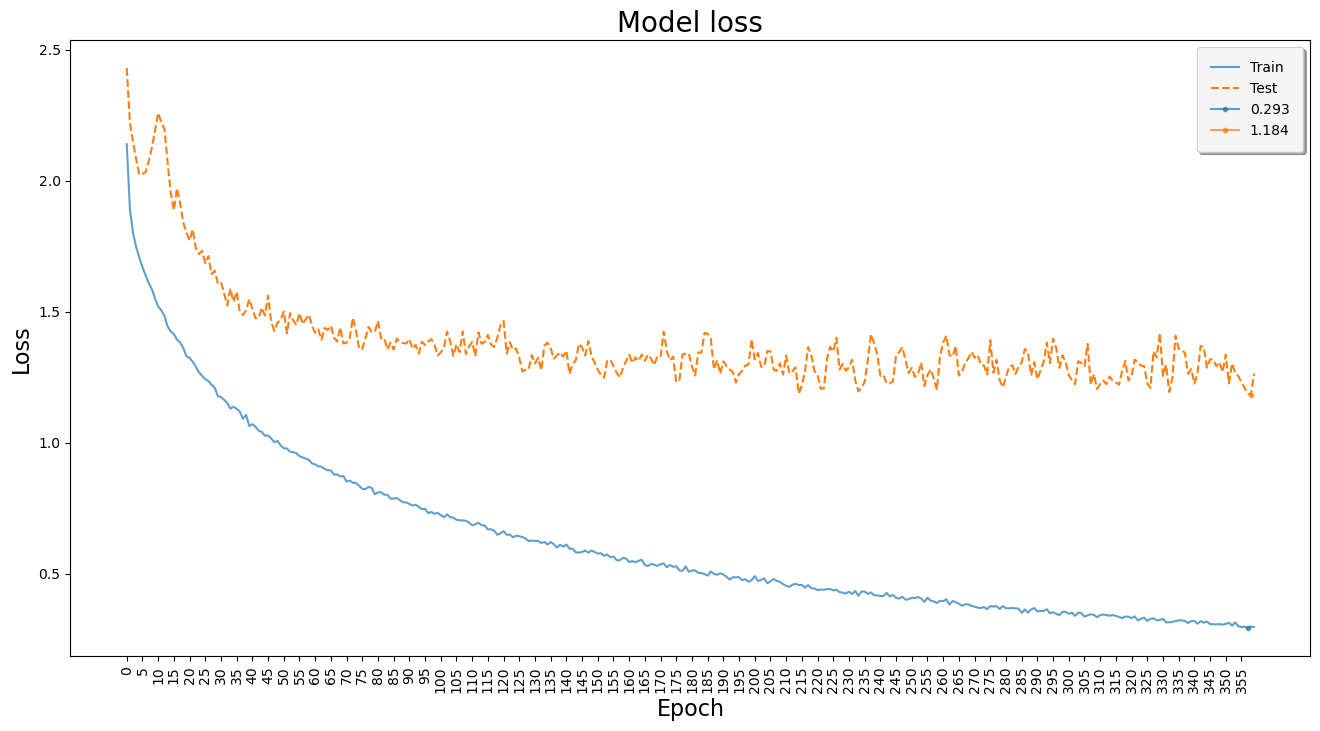

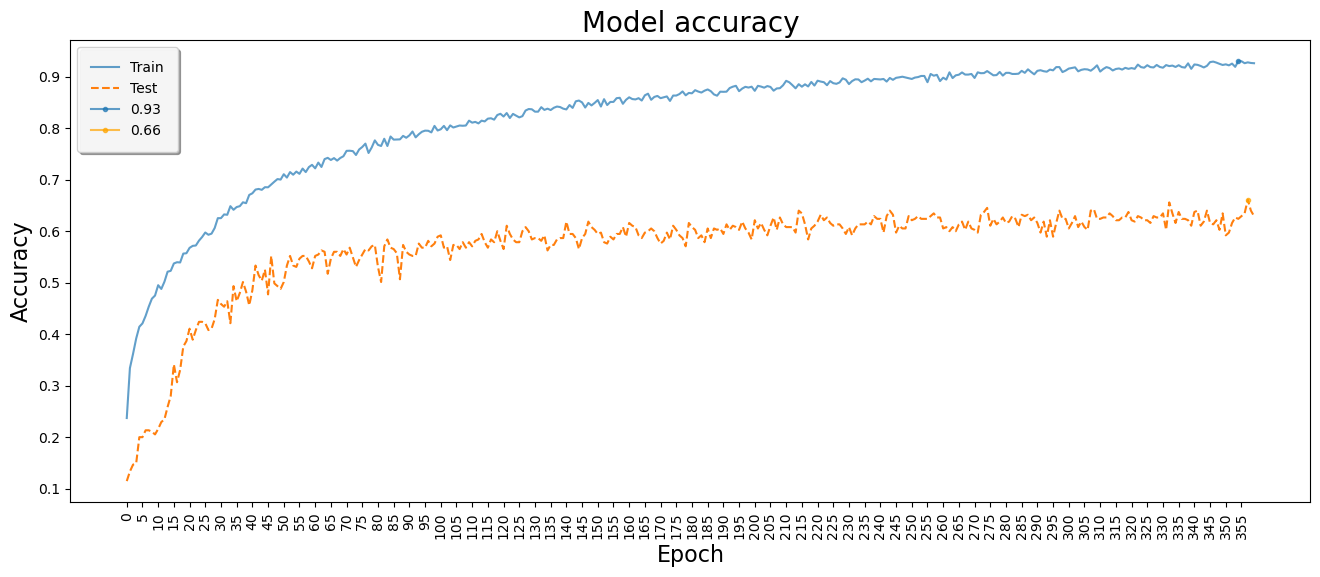

In [24]:
helpers.plot_train_history(history, x_ticks_vertical=True)

# Model evaluation

Register model output

In [25]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

# Confussion matrix

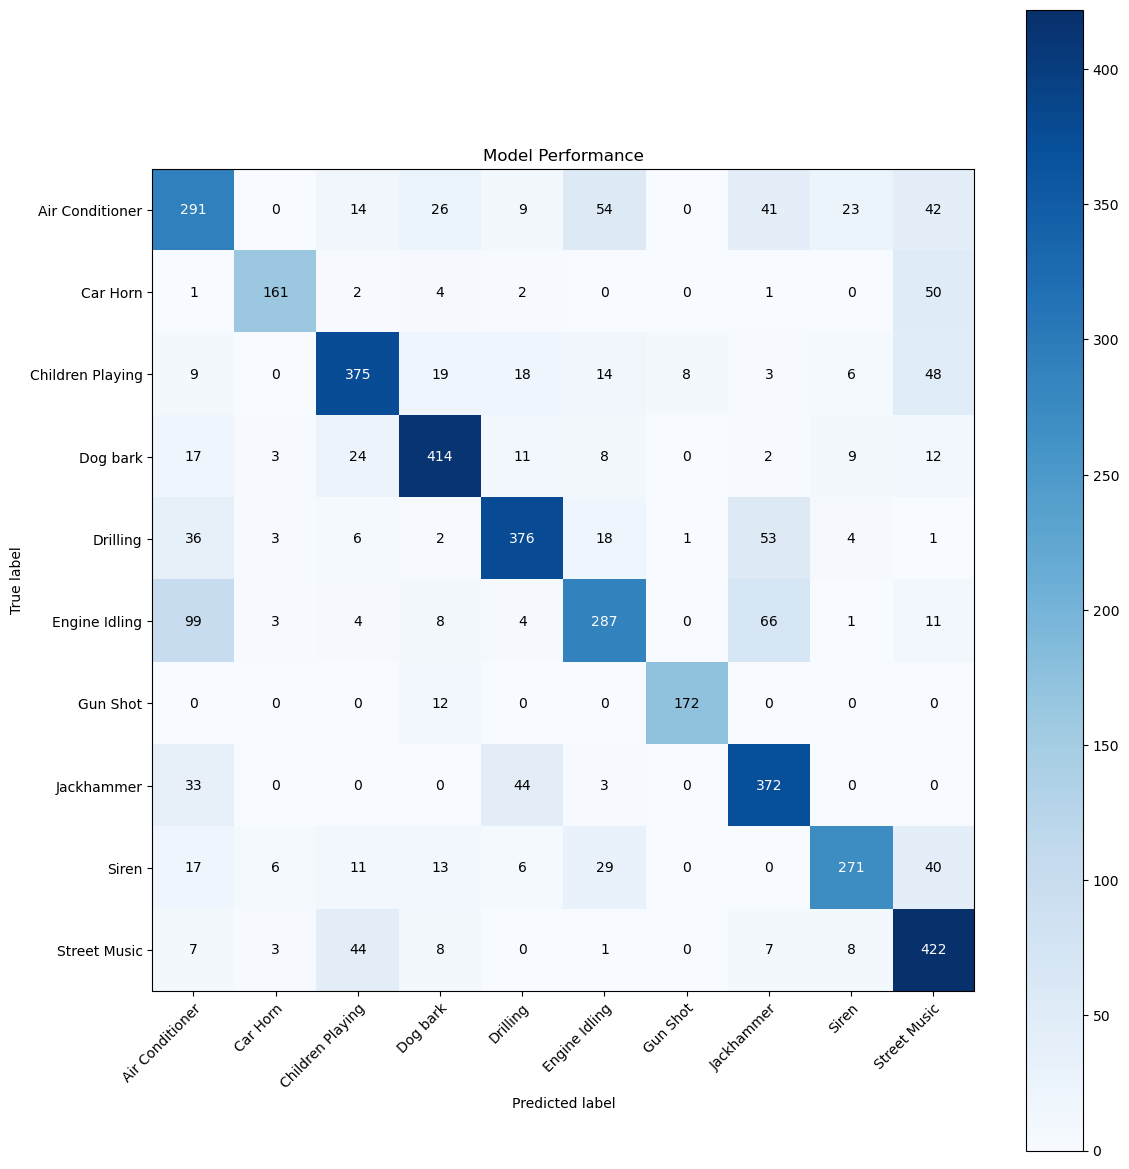

In [26]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

# Accuracy table

In [27]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,93.478261
9,Street Music,84.400000
3,Dog bark,82.800000
7,Jackhammer,82.300885
4,Drilling,75.200000
2,Children Playing,75.000000
1,Car Horn,72.850679
8,Siren,68.956743
5,Engine Idling,59.420290
0,Air Conditioner,58.200000


# Classification performance: Presicion, Recall and F1 scores


In [28]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.57      0.58      0.58       500
        Car Horn       0.90      0.73      0.80       221
Children Playing       0.78      0.75      0.77       500
        Dog bark       0.82      0.83      0.82       500
        Drilling       0.80      0.75      0.78       500
   Engine Idling       0.69      0.59      0.64       483
        Gun Shot       0.95      0.93      0.94       184
      Jackhammer       0.68      0.82      0.75       452
           Siren       0.84      0.69      0.76       393
    Street Music       0.67      0.84      0.75       500

        accuracy                           0.74      4233
       macro avg       0.77      0.75      0.76      4233
    weighted avg       0.75      0.74      0.74      4233

